In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T153203Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ad75dae4189c8b8458983ac813fa534c0d9efb47df62a1f138ccded7836a2c3a9ac147017af9fbf6d3a73daa57432b0c29429dc4acfe49ec2b1407383262e28d2b20c8c9980a6f8403f326ec5b8f2dd51565696da00e3a6e777113c67293209a820c7b4f0516c39a65b356c3239cfbd1b1fab14a0df1665cfc3a09ab48e3ef0cb9ef54f3dc27c48dc695f044f3c305131ba966ece2a1057eae25313815e1730b328478af8dadcfd5487efe63f84d79ace11bed7bf416fcac64dc22a551883aa9c2055ef16e3aa92b91bcd75727f70e6bc5802b586009d55d60f94d26ae4e0586d62765080bcc7ae9ca465420a036223b67e09489184b72af17b2d7f6ec8f51d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


# 1.Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import torchvision as tv
from torchvision.datasets import MNIST

# 2.Importing Dataset

In [ ]:
validation  = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test= pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
sample_submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

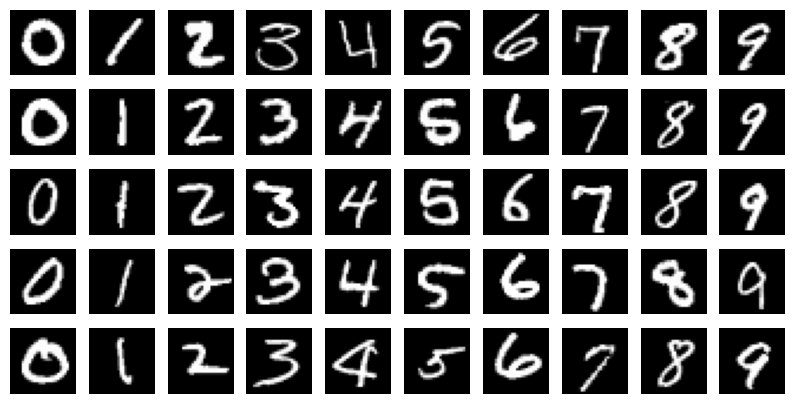

In [ ]:
rows = 5
fig, axes = plt.subplots(rows, 10, figsize=(10 ,rows))

for i in range (10 ):
    ds  = validation[validation.label == i]
    for j in range(rows):
        ax = axes[j,i]
        ax.imshow(ds.iloc[j,1:].values.reshape(28,28), cmap='gray')
        ax.axis('off')

plt.show()

# 3. Preprocessing of Data
- Loading extra data from PyTorch
- Construction of data loader
- Normalizing the data
- Converting data into tensor

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255)
])


x1 = MNIST("/data", download = True, train=True, transform=transform)
x2 = MNIST("/data", train = False, transform=transform)
train = torch.utils.data.ConcatDataset([x1, x2])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class TensorFromDataset(Dataset):
    def __init__ (self, dataFrame, transform = transforms.ToTensor()):
        self.dataFrame = dataFrame

    def __len__ (self):
        return len(self.dataFrame)

    def __getitem__ (self, index):
        label = self.dataFrame.iloc[index, 0]
        image = self.dataFrame.iloc[index, 1:].values.astype(np.uint8).reshape(28, 28)
        label = torch.tensor(label)
        if transform is not None:
            image = transform(image)
        return (image, label)

validation_data = TensorFromDataset(validation, transform = transform)
test_data = transform(test.values.astype(np.uint8))

In [ ]:
batch_size = 32 ** 2

train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

# 4. Making Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.main =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size  = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size  = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size  = 3, stride = 1, padding = 1),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128 * 3),
            nn.ReLU(),
            nn.Linear(128 * 3 , 10),
            nn.Softmax()
        )
        self.to(device)
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001)
        self.validation_step = self.training_step
        self.history = []
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        return self.main(x)

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim = 1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        out = self(images)
        loss = self.loss(out, labels)
        accuracy = self.accuracy(out, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item(), accuracy.item()

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            out = self(images)
            loss = self.loss(out, labels)
            accuracy = self.accuracy(out, labels)

            return loss.item() , accuracy.item()

    def training_epoch_end(self, t_accuracy, t_loss, v_accuracy, v_loss):
        epoch = len(self.history)
        self.history.append({
            'epoch' : epoch + 1,
            'training_accuracy' : t_accuracy,
            'training_loss' : t_loss,
            'validation_accuracy' : v_accuracy,
            'validation_loss' : v_loss,
        })
        print (self.history[-1])


    def plot_history(self):
        df = pd.DataFrame(self.history)
        fig, axes  = plt.subplots(1, 2, figsize = (15, 5))
        losses = df[['training_loss', 'validation_loss']]
        accuracies = df[['training_accuracy', 'validation_accuracy']]
        losses.plot(ax = axes[0])
        accuracies.plot(ax = axes[1])
        axes[0].set_title('Loss over epochs')
        axes[1].set_title('Accuracy over epochs')
        axes[0].set_xlabel('Epoch')
        axes[1].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[1].set_ylabel('Accuracy')
        plt.show()


    def training_loop(self, epochs, ):
        for epoch in range(epochs):
            for training_batch in train_loader:
                t_loss, t_accuracy = self.training_step(training_batch)

            for validation_batch in validation_loader:
                v_loss, v_accuracy = self.validation_step(validation_batch)

            self.training_epoch_end(t_accuracy, t_loss, v_accuracy, v_loss)

digitRecognizer = Model()

# 5. Training model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define your model architecture (example with a simple CNN)
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Load and preprocess your dataset (example MNIST)
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Define your training loop with optimizations
def training_loop(epochs=10, batch_size=32):
    model = create_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_test, y_test), callbacks=[early_stopping])

    return model, history

# Example usage
trained_model, training_history = training_loop(epochs=10, batch_size=32)


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.1345 - accuracy: 0.9586 - val_loss: 0.0507 - val_accuracy: 0.9826
Epoch 2/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.0369 - val_accuracy: 0.9872
Epoch 3/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0327 - accuracy: 0.9900 - val_loss: 0.0432 - val_accuracy: 0.9869
Epoch 4/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0352 - val_accuracy: 0.9890
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0179 - accuracy: 0.9937 - val_loss: 0.0336 - val_accuracy: 0.9890
Epoch 6/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0280 - val_accuracy: 0.9910
Epoch 7/10
1875/1875 [==============================] - 45s

In [ ]:
# i am also saveing the model after training it for 500 epochs
torch.save({'model' : digitRecognizer.state_dict(),
            'optimizer' : digitRecognizer.optimizer.state_dict() }, 'digitRecognizer.pth')

# 6. Looking at model performanc


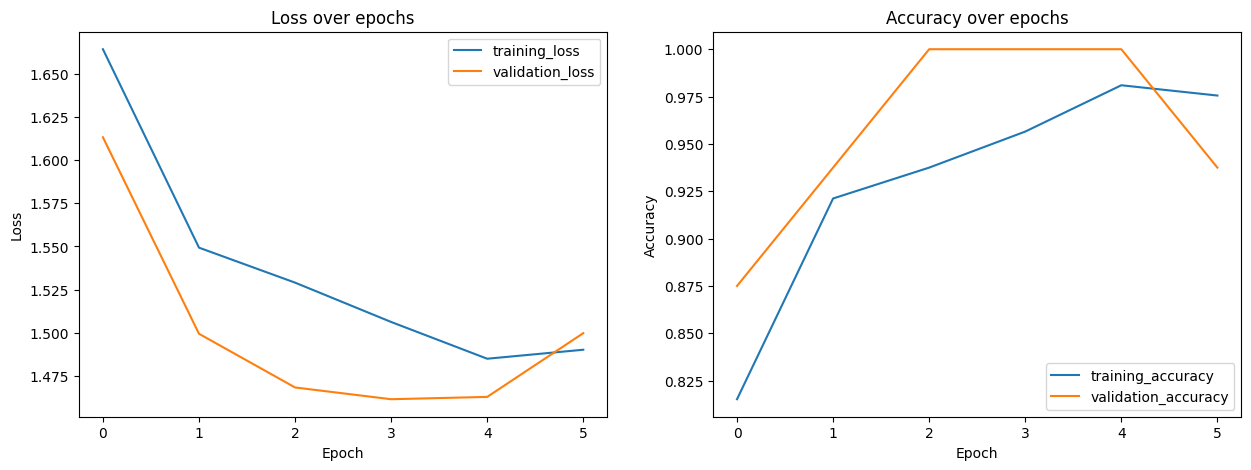

In [ ]:
digitRecognizer.plot_history()

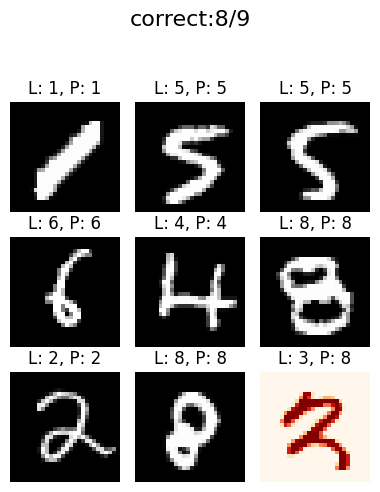

In [ ]:
def random_test(rows= 1, cols =1 ):
    total = rows * cols
    correct = total
    random_indices = np.random.randint(len(validation), size=total)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.3  ,1.8* rows) )

    random_images = validation.iloc[random_indices, 1:].values.astype(np.uint8)
    labels = validation.iloc[random_indices, 0].values
    images_tensor = transform(random_images)
    images_tensor = images_tensor.to(device)
    images_tensor = images_tensor.reshape(-1, 1, 28, 28)

    predictions_p = digitRecognizer(images_tensor)
    _, predictions = torch.max(predictions_p, dim = 1)
    predictions = predictions.cpu().numpy()

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            image = random_images[index]
            label = labels[index]
            prediction = predictions[index]
            if rows == 1 and cols ==1:
                ax = axes
            elif rows ==1 :
                ax = axes[j]
            elif cols == 1:
                ax = axes[i]
            else:
                ax = axes[i][j]
            cmap = 'gray'
            if label != prediction:
                correct -= 1
                cmap = 'OrRd'
            ax.imshow(image.reshape(28, 28), cmap=cmap)
            ax.set_title(f'L: {label}, P: {prediction}')
            ax.axis(False)
        fig.suptitle(f'correct:{correct}/{total}', fontsize=16)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    del images_tensor
    del predictions_p
    del predictions
    torch.cuda.empty_cache()
    plt.show()

random_test(3,3)

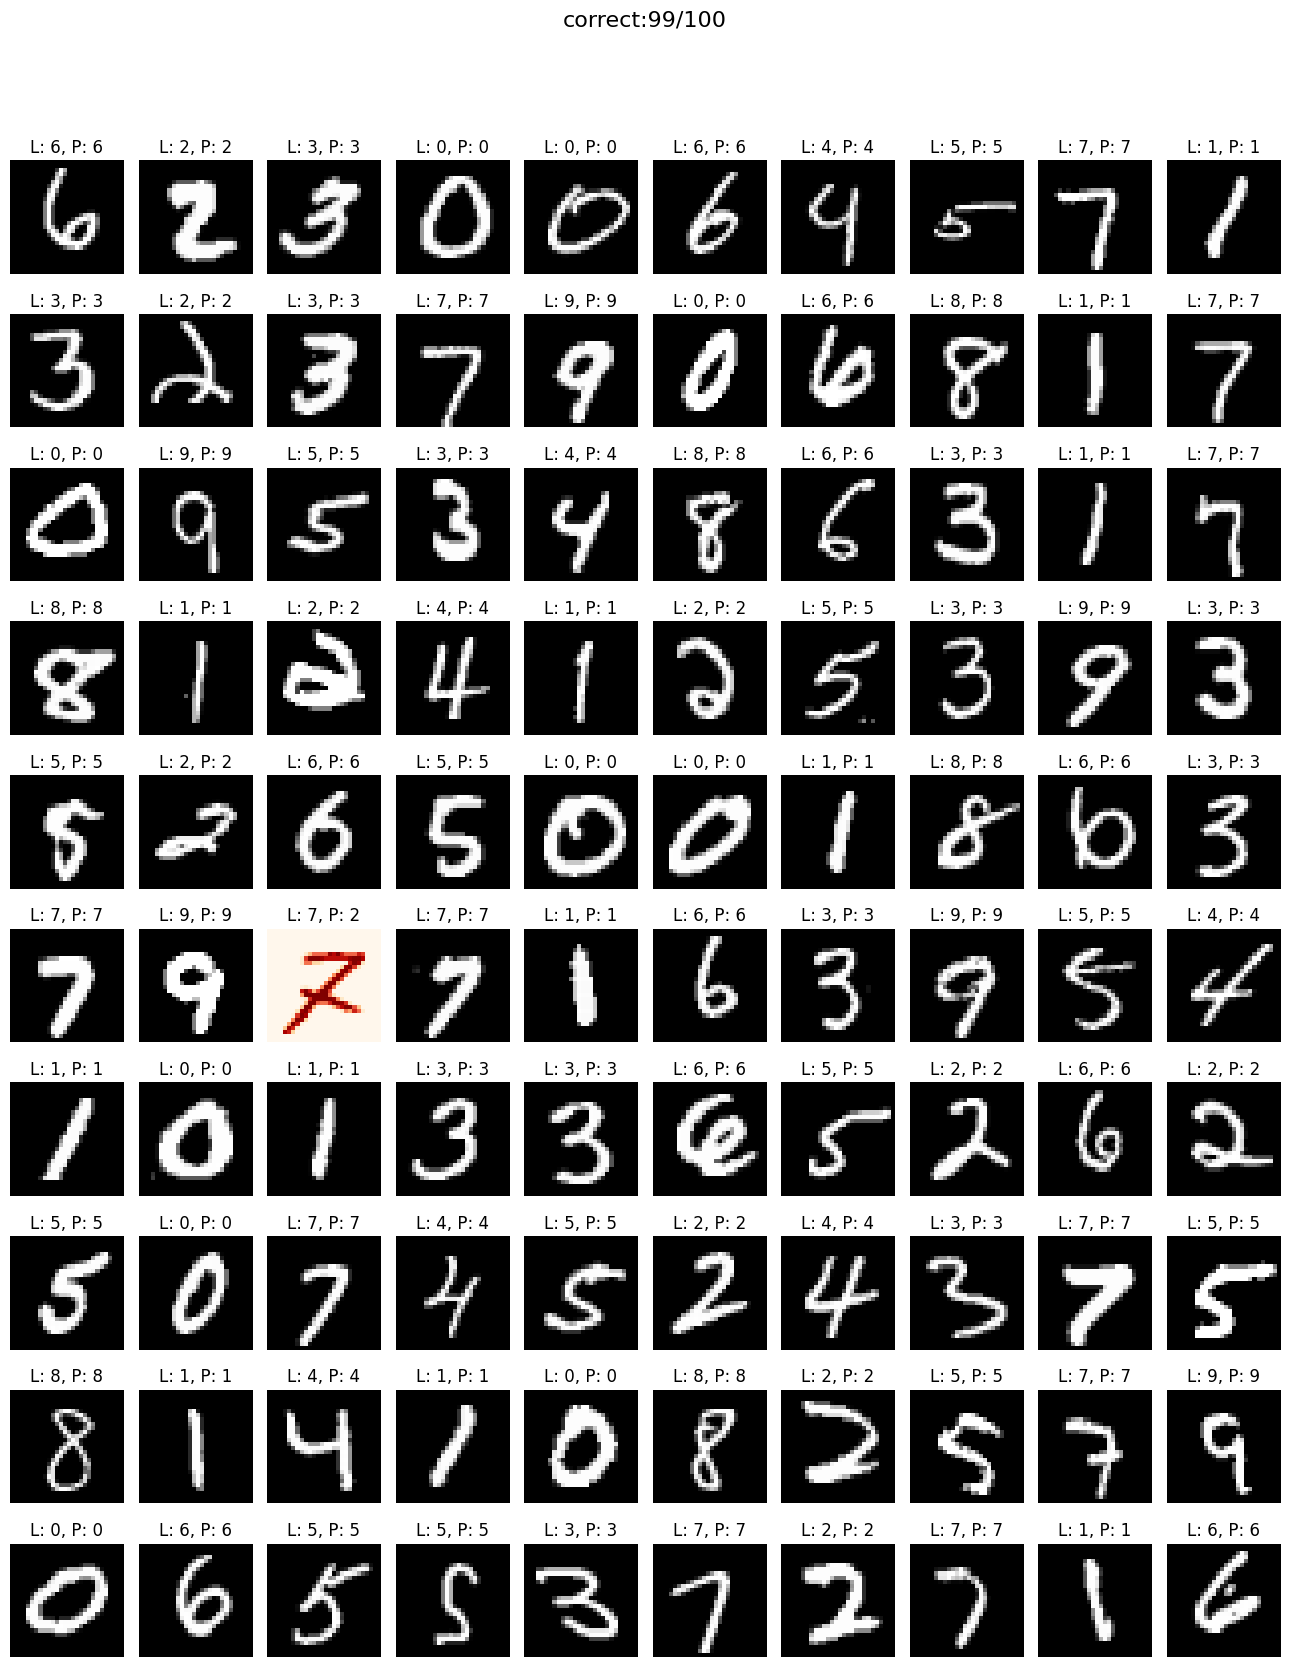

In [ ]:
random_test(10 ,10)

# 7. submission

In [ ]:
test_data = test_data.to(device)
test_data_batch = test_data.reshape(1000, 28, 1, 28, 28)

predictions_p = np.array([])
for t in test_data_batch:
    predictions_p = np.append(predictions_p, digitRecognizer(t).detach().cpu().numpy())

predictions_p = torch.from_numpy(predictions_p.reshape(-1, 10))

_, predictions = torch.max(predictions_p, dim = 1)
predictions = predictions.cpu().numpy()

sample_submission['Label'] = predictions
sample_submission.to_csv('submission.csv', index=False)